In [467]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
import matplotlib
import datetime as dt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [468]:
data = pd.read_excel("datasets/online_retail_II-230817-120704.xlsx", sheet_name="Year 2010-2011")

In [469]:
df = data.copy()
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [470]:
def missing_values_analysis(df):
    na_columns_ = [col for col in df.columns if df[col].isnull().sum() > 0]
    n_miss = df[na_columns_].isnull().sum().sort_values(ascending=False)
    ratio_ = (df[na_columns_].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio_, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df).sort_values(by="Ratio", ascending=False)
    return missing_df


def check_df(df, head=5):
    print("Info".center(100, '~'))
    print(df.info())
    print(" Dataframe - Head ".center(100, '~'))
    print(df.head(head))
    print("Unique Values".center(100, '~'))
    print(df.nunique())
    print(" Missing Values Analysis ".center(100, '~'))
    print(missing_values_analysis(df))
    print(' Duplicate Values Analysis '.center(100, '~'))
    print(df.duplicated().sum())
    print(" QUANTILES ".center(100, '~'))
    print(df.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


check_df(df)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~Info~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      541910 non-null  object        
 1   StockCode    541910 non-null  object        
 2   Description  540456 non-null  object        
 3   Quantity     541910 non-null  int64         
 4   InvoiceDate  541910 non-null  datetime64[ns]
 5   Price        541910 non-null  float64       
 6   Customer ID  406830 non-null  float64       
 7   Country      541910 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ Dataframe - Head ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
  Invoice StockCode                          Description  Quantity  \
0  536365    85123A   WHITE HAN

In [471]:
def select_country(dataframe, country):
    new_dataframe = dataframe.loc[dataframe["Country"] == country]
    return new_dataframe


def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True, len(dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)])
    else:
        return False


def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [472]:
df = df[~df["Invoice"].str.contains ("C", na=False)] # Canceled orders are removed.
df = df[(df['Quantity'] > 0)] # Quantity values less than 0 are removed.
df.dropna(inplace=True)

In [473]:
df.groupby("Description").agg({"Quantity": "sum"}).sort_values("Quantity", ascending=False)

,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
JUMBO BAG RED RETROSPOT,46181
WHITE HANGING HEART T-LIGHT HOLDER,36725
...,...
BLACK VINT ART DEC CRYSTAL BRACELET,1
FLOWER SHOP DESIGN MUG,1
SET 36 COLOURING PENCILS DOILEY,1


In [474]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,397925.0,13.021793,1.0,2.0,6.0,12.0,80995.0,180.419984
InvoiceDate,397925,2011-07-10 23:44:09.817126400,2010-12-01 08:26:00,2011-04-07 11:12:00,2011-07-31 14:39:00,2011-10-20 14:33:00,2011-12-09 12:50:00,NaN
Price,397925.0,3.116212,0.0,1.25,1.95,3.75,8142.75,22.096773
Customer ID,397925.0,15294.308601,12346.0,13969.0,15159.0,16795.0,18287.0,1713.172738


In [475]:
df['TotalPrice'] = df["Price"] * df["Quantity"]

In [476]:
# today_date = dt.datetime.now() 
today_date = dt.datetime(2011, 12, 11)

In [477]:
df = df[df["StockCode"] != "M"]
invalid_codes = df[df["StockCode"].astype(str).str.contains(
    r"[a-zA-Z]{3,}")]["StockCode"].unique().tolist()
invalid_codes

['POST', 'BANK CHARGES', 'PADS', 'DOT']

In [478]:
print(
    df[df["StockCode"].isin(invalid_codes)].groupby(["StockCode"]).agg({"Invoice": "nunique",
                                                                        "Quantity": "sum",
                                                                        "Price": "sum",
                                                                        "Customer ID": "nunique"})
)
df = df[~df["StockCode"].isin(invalid_codes)].reset_index(drop=True)

              Invoice  Quantity      Price  Customer ID
StockCode                                              
BANK CHARGES       11        12    165.001           10
DOT                16        16  11906.360            1
PADS                4         4      0.003            4
POST             1100      3121  34713.960          331


In [479]:
# InvoiceDate = recency
# Invoice = frequency
# TotalPrice = monetary

rfm = df.groupby("Customer ID").agg(
    {"InvoiceDate": lambda recency: (today_date - recency.max()).days,
     "Invoice": lambda frequency: frequency.nunique(),
     "TotalPrice": lambda monetary: monetary.sum()
     })
rfm.columns = ["RECENCY", "FREQUENCY", "MONETARY"]
rfm.head()

,RECENCY,FREQUENCY,MONETARY
Customer ID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1437.24
12349.0,19,1,1457.55
12350.0,311,1,294.40


In [480]:
for col in rfm.columns:
    print(col, check_outlier(rfm, col))
    if check_outlier(rfm, col):
        replace_with_thresholds(rfm, col)

RECENCY False
FREQUENCY (True, 38)
MONETARY (True, 62)


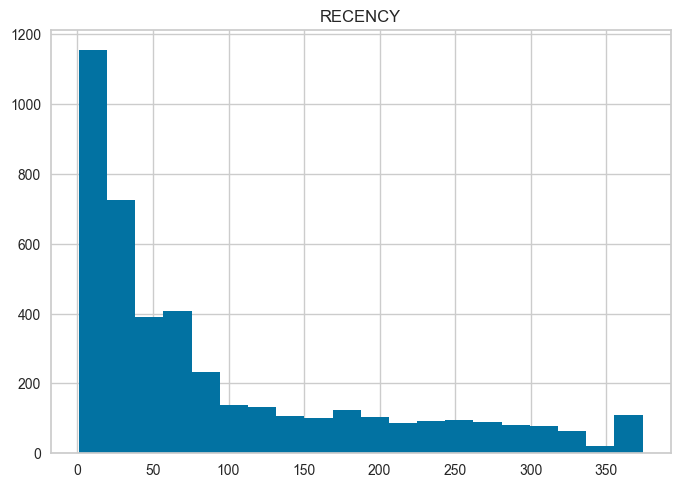

In [481]:
rfm["RECENCY"].hist(bins=20)
plt.title("RECENCY")
plt.show()

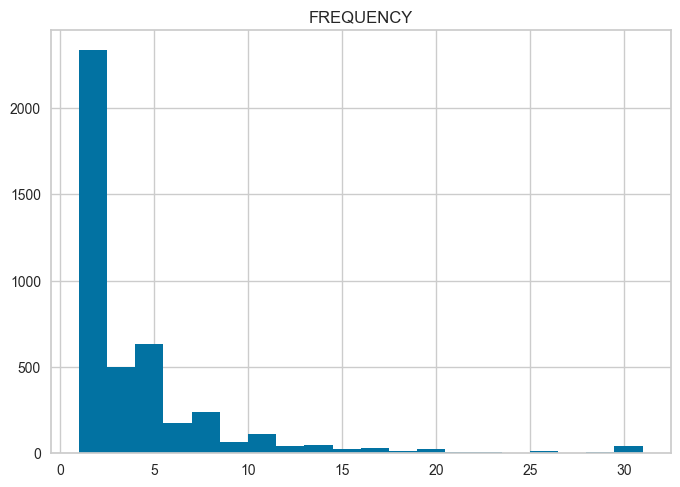

In [482]:
rfm["FREQUENCY"].hist(bins=20)
plt.title("FREQUENCY")
plt.show()

In [483]:
rfm["RECENCY_SCORE"] = pd.qcut(rfm['RECENCY'], 5, labels=[5, 4, 3, 2, 1])
rfm["FREQUENCY_SCORE"] = pd.qcut(rfm['FREQUENCY'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
rfm["MONETARY_SCORE"] = pd.qcut(rfm['MONETARY'], 5, labels=[1, 2, 3, 4, 5])
rfm["RFM_SCORE"] = rfm['RECENCY_SCORE'].astype(str) + rfm['FREQUENCY_SCORE'].astype(str) + rfm['MONETARY_SCORE'].astype(str)
rfm['SEGMENT'] = rfm['RECENCY_SCORE'].astype(str) + rfm['FREQUENCY_SCORE'].astype(str)

In [484]:
# Regular Expressions(Regex)
seg_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At Risk',
    r'[1-2]5': 'Can\'t Loose',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}


rfm['SEGMENT'] = rfm['SEGMENT'].replace(seg_map, regex=True)

In [485]:
rfm.head()

,RECENCY,FREQUENCY,MONETARY,RECENCY_SCORE,FREQUENCY_SCORE,MONETARY_SCORE,RFM_SCORE,SEGMENT
Customer ID,,,,,,,,
12346.0,326,1,14194.036,1,1,5,115,Hibernating
12347.0,3,7,4310.000,5,5,5,555,Champions
12348.0,76,4,1437.240,2,4,4,244,At Risk
12349.0,19,1,1457.550,4,1,4,414,Promising
12350.0,311,1,294.400,1,1,2,112,Hibernating


In [486]:
rfm[["SEGMENT", "RECENCY", "FREQUENCY", "MONETARY"]].groupby("SEGMENT").agg(["mean", "count"])


RECENCY        FREQUENCY           MONETARY      
                           mean count       mean count         mean count
SEGMENT                                                                  
About to Sleep        53.471264   348   1.140805   348   472.027759   348
At Risk              153.545918   588   2.863946   588   981.724782   588
Can't Loose          135.301587    63   8.238095    63  2734.523175    63
Champions              6.679389   655  10.645802   655  4043.844455   655
Hibernating          218.150979  1073   1.097856  1073   421.309558  1073
Loyal Customers       34.223058   798   6.303258   798  2473.919937   798
Need Attention        52.417989   189   2.312169   189   832.725291   189
New Customers          8.297872    47   1.000000    47   350.327021    47
Potential Loyalists   17.437113   485   1.997938   485   708.214796   485
Promising             23.898876    89   1.000000    89   286.601461    89

# Clustering with the K-Means Algorithm

In [487]:
# LOG TRANSFORMATION
for col in ["RECENCY", "FREQUENCY", "MONETARY"]:
    rfm[f"LOG_{col}"] = np.log1p(rfm[col])

# SCALER
sc = MinMaxScaler((0, 1))
sc.fit(rfm[["LOG_RECENCY", "LOG_FREQUENCY", "LOG_MONETARY"]])
scaled_rf = sc.transform(rfm[["LOG_RECENCY", "LOG_FREQUENCY", "LOG_MONETARY"]])

scaled_df = pd.DataFrame(index=rfm.index, columns=[
                         "LOG_RECENCY", "LOG_FREQUENCY", "LOG_MONETARY"], data=scaled_rf)
scaled_df

,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETARY
Customer ID,,,
12346.0,0.973830,0.000000,1.000000
12347.0,0.132437,0.500000,0.875351
12348.0,0.697519,0.330482,0.760532
12349.0,0.439947,0.000000,0.761998
12350.0,0.964859,0.000000,0.594973
...,...,...,...
18280.0,0.943499,0.000000,0.544085
18281.0,0.861874,0.000000,0.460693
18282.0,0.287379,0.146241,0.542606


# Determining the Optimum Number of Clusters

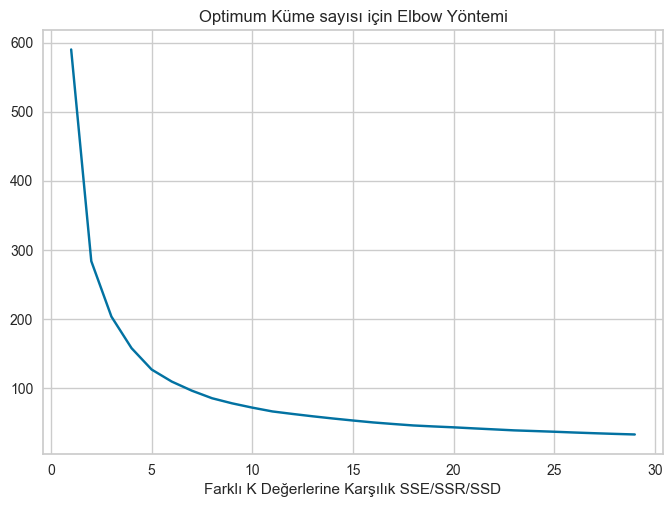

In [488]:
kmeans = KMeans()
ssd = []
K = range(1, 30)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(scaled_df)
    ssd.append(kmeans.inertia_)

plt.plot(K, ssd, "bx-")
plt.xlabel("Farklı K Değerlerine Karşılık SSE/SSR/SSD")
plt.title("Optimum Küme sayısı için Elbow Yöntemi")
plt.show()

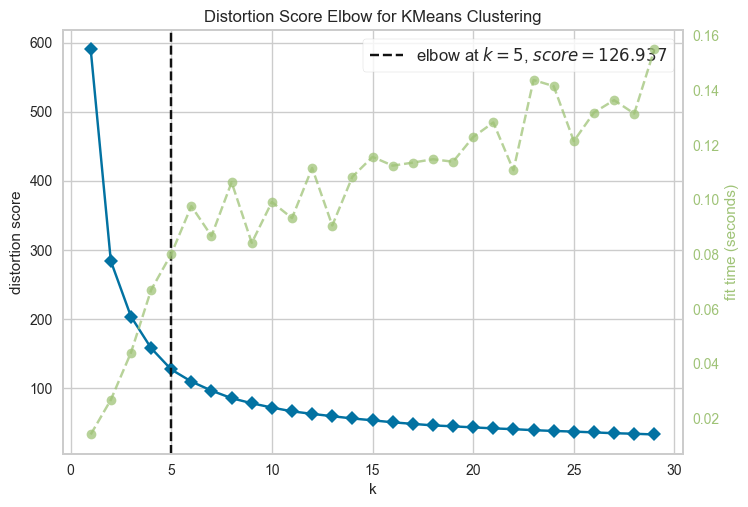

In [489]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
elbow = KElbowVisualizer(kmeans, k=K).fit(scaled_df)
elbow.show();

In [490]:
# Final Cluster'ların Oluşturulması
kmeans = KMeans(n_clusters=elbow.elbow_value_).fit(scaled_df)

print(kmeans.n_clusters)
print(kmeans.cluster_centers_)
print(kmeans.labels_)

clusters_kmeans = kmeans.labels_

5
[[0.64396444 0.36639678 0.76042296]
 [0.30205324 0.28134116 0.7151114 ]
 [0.89594533 0.05069955 0.59556817]
 [0.58815257 0.05891065 0.61263476]
 [0.28371134 0.6960111  0.87990494]]
[2 4 0 ... 1 4 0]


In [491]:
rfm["clusters_kmeans"] = clusters_kmeans
rfm.clusters_kmeans = rfm.clusters_kmeans + 1
rfm.groupby("clusters_kmeans").agg({"clusters_kmeans": "count"})

,clusters_kmeans
clusters_kmeans,
1,900
2,661
3,1211
4,1031
5,532


In [492]:
rfm.groupby("clusters_kmeans").agg({"RECENCY": ["mean", "median", "count"],
                                    "FREQUENCY": ["mean", "median", "count"],
                                    "MONETARY": ["mean", "median", "count"]})

RECENCY               FREQUENCY                  MONETARY  \
                       mean median count       mean median count         mean   
clusters_kmeans                                                                 
1                 69.202222   55.0   900   4.812222    4.0   900  1869.194131   
2                 10.711044   10.0   661   3.588502    3.0   661  1258.111053   
3                230.286540  227.0  1211   1.366639    1.0  1211   438.209419   
4                 48.516974   47.0  1031   1.408341    1.0  1031   481.827003   
5                 10.900376    9.0   532  14.122180   12.0   532  5620.840154   

                                
                  median count  
clusters_kmeans                 
1                1427.09   900  
2                 966.60   661  
3                 306.13  1211  
4                 355.56  1031  
5                4216.48   532

In [494]:
dummy_df = pd.get_dummies(rfm["clusters_kmeans"], dtype=int,  prefix="KMeans_")
rfm = pd.concat([rfm, dummy_df], axis=1)
rfm

,RECENCY,FREQUENCY,MONETARY,RECENCY_SCORE,FREQUENCY_SCORE,MONETARY_SCORE,RFM_SCORE,SEGMENT,LOG_RECENCY,LOG_FREQUENCY,LOG_MONETARY,clusters_kmeans,KMeans__1,KMeans__2,KMeans__3,KMeans__4,KMeans__5
Customer ID,,,,,,,,,,,,,,,,,
12346.0,326,1,14194.036,1,1,5,115,Hibernating,5.789960,0.693147,9.560648,3,0,0,1,0,0
12347.0,3,7,4310.000,5,5,5,555,Champions,1.386294,2.079442,8.368925,5,0,0,0,0,1
12348.0,76,4,1437.240,2,4,4,244,At Risk,4.343805,1.609438,7.271175,1,1,0,0,0,0
12349.0,19,1,1457.550,4,1,4,414,Promising,2.995732,0.693147,7.285198,4,0,0,0,1,0
12350.0,311,1,294.400,1,1,2,112,Hibernating,5.743003,0.693147,5.688330,3,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,278,1,180.600,1,2,1,121,Hibernating,5.631212,0.693147,5.201806,3,0,0,1,0,0
18281.0,181,1,80.820,1,2,1,121,Hibernating,5.204007,0.693147,4.404522,3,0,0,1,0,0
18282.0,8,2,178.050,5,3,1,531,Potential Loyalists,2.197225,1.098612,5.187665,2,0,1,0,0,0


In [497]:
rfm.groupby("SEGMENT").agg({"KMeans__1": "sum",
                            "KMeans__2": "sum",
                            "KMeans__3": "sum",
                            "KMeans__4": "sum",
                            "KMeans__5": "sum"})

,KMeans__1,KMeans__2,KMeans__3,KMeans__4,KMeans__5
SEGMENT,,,,,
About to Sleep,0,0,0,348,0
At Risk,250,0,288,50,0
Can't Loose,62,0,0,0,1
Champions,0,269,0,0,386
Hibernating,2,0,923,148,0
Loyal Customers,507,136,0,10,145
Need Attention,58,0,0,131,0
New Customers,0,20,0,27,0
Potential Loyalists,21,236,0,228,0


# Hierarchical Clustering

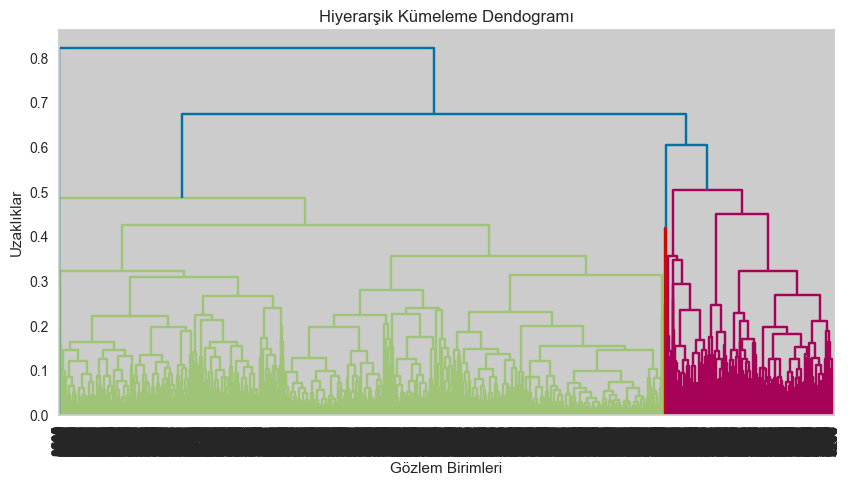

In [498]:
hc_average = linkage(scaled_df, "average")
plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           leaf_font_size=10)
plt.show()

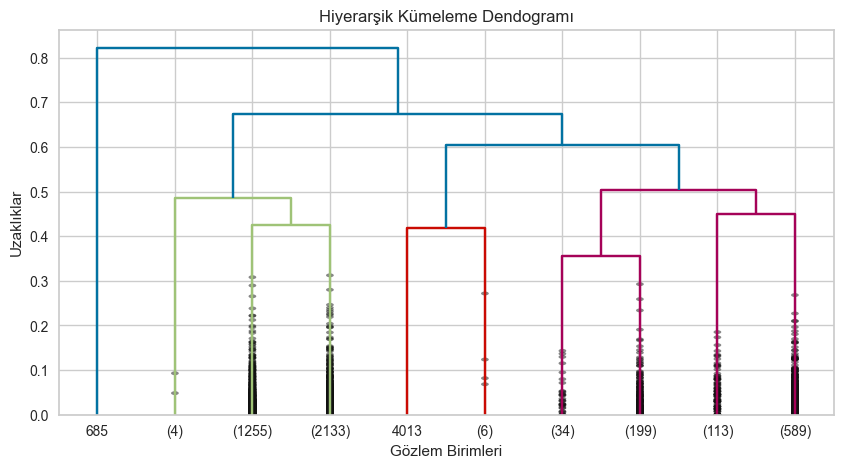

In [499]:
plt.figure(figsize=(10, 5))
plt.title("Hiyerarşik Kümeleme Dendogramı")
plt.xlabel("Gözlem Birimleri")
plt.ylabel("Uzaklıklar")
dendrogram(hc_average,
           truncate_mode="lastp",
           p=10,
           show_contracted=True,
           leaf_font_size=10)
plt.show()


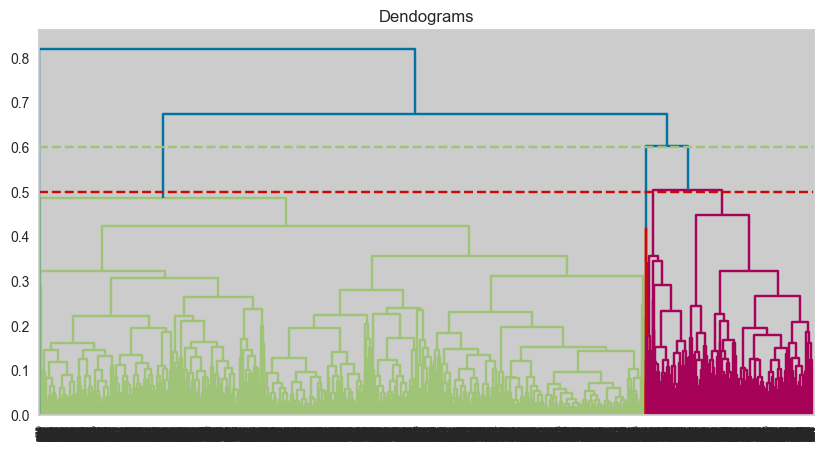

In [500]:
# Kume Sayısını Belirlemek

plt.figure(figsize=(10, 5))
plt.title("Dendograms")
dend = dendrogram(hc_average)
plt.axhline(y=0.5, color="r", linestyle="--")
plt.axhline(y=0.6, color="g", linestyle="--")
plt.show()

In [501]:
# Final Modeli Oluşturmak

from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=5, linkage="average")
hierarchical_clusters = cluster.fit_predict(scaled_df)
rfm["hierarchical_clusters"] = hierarchical_clusters
rfm.hierarchical_clusters = rfm.hierarchical_clusters + 1

In [502]:
rfm.groupby("hierarchical_clusters").agg({"RECENCY": ["mean", "median", "count"],
                                    "FREQUENCY": ["mean", "median", "count"],
                                    "MONETARY": ["mean", "median", "count"]})

RECENCY               FREQUENCY               \
                             mean median count       mean median count   
hierarchical_clusters                                                    
1                      115.920106   73.0  3392   2.317217    2.0  3392   
2                      109.428571   81.0     7  22.142857   17.0     7   
3                       13.034188   10.0   702  12.176638   10.0   702   
4                       15.000000   15.0     1   1.000000    1.0     1   
5                        3.978541    4.0   233   3.257511    3.0   233   

                          MONETARY                  
                              mean    median count  
hierarchical_clusters                               
1                       835.578160   496.790  3392  
2                      5550.248000  5391.210     7  
3                      4836.224718  3504.405   702  
4                         0.000000     0.000     1  
5                      1130.668352   813.520   233

In [503]:
dummy_df2 = pd.get_dummies(rfm["hierarchical_clusters"], dtype=int,  prefix="Hierarchical_")
rfm = pd.concat([rfm, dummy_df2], axis=1)
rfm

,RECENCY,FREQUENCY,MONETARY,RECENCY_SCORE,FREQUENCY_SCORE,MONETARY_SCORE,RFM_SCORE,SEGMENT,LOG_RECENCY,LOG_FREQUENCY,...,KMeans__2,KMeans__3,KMeans__4,KMeans__5,hierarchical_clusters,Hierarchical__1,Hierarchical__2,Hierarchical__3,Hierarchical__4,Hierarchical__5
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346.0,326,1,14194.036,1,1,5,115,Hibernating,5.789960,0.693147,...,0,1,0,0,1,1,0,0,0,0
12347.0,3,7,4310.000,5,5,5,555,Champions,1.386294,2.079442,...,0,0,0,1,3,0,0,1,0,0
12348.0,76,4,1437.240,2,4,4,244,At Risk,4.343805,1.609438,...,0,0,0,0,1,1,0,0,0,0
12349.0,19,1,1457.550,4,1,4,414,Promising,2.995732,0.693147,...,0,0,1,0,1,1,0,0,0,0
12350.0,311,1,294.400,1,1,2,112,Hibernating,5.743003,0.693147,...,0,1,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280.0,278,1,180.600,1,2,1,121,Hibernating,5.631212,0.693147,...,0,1,0,0,1,1,0,0,0,0
18281.0,181,1,80.820,1,2,1,121,Hibernating,5.204007,0.693147,...,0,1,0,0,1,1,0,0,0,0
18282.0,8,2,178.050,5,3,1,531,Potential Loyalists,2.197225,1.098612,...,1,0,0,0,1,1,0,0,0,0


In [504]:
rfm.groupby("SEGMENT").agg({"Hierarchical__1": "sum",
                            "Hierarchical__2": "sum",
                            "Hierarchical__3": "sum",
                            "Hierarchical__4": "sum",
                            "Hierarchical__5": "sum"})

,Hierarchical__1,Hierarchical__2,Hierarchical__3,Hierarchical__4,Hierarchical__5
SEGMENT,,,,,
About to Sleep,348,0,0,0,0
At Risk,588,0,0,0,0
Can't Loose,57,5,1,0,0
Champions,69,0,464,0,122
Hibernating,1073,0,0,0,0
Loyal Customers,558,2,237,0,1
Need Attention,189,0,0,0,0
New Customers,25,0,0,1,21
Potential Loyalists,396,0,0,0,89


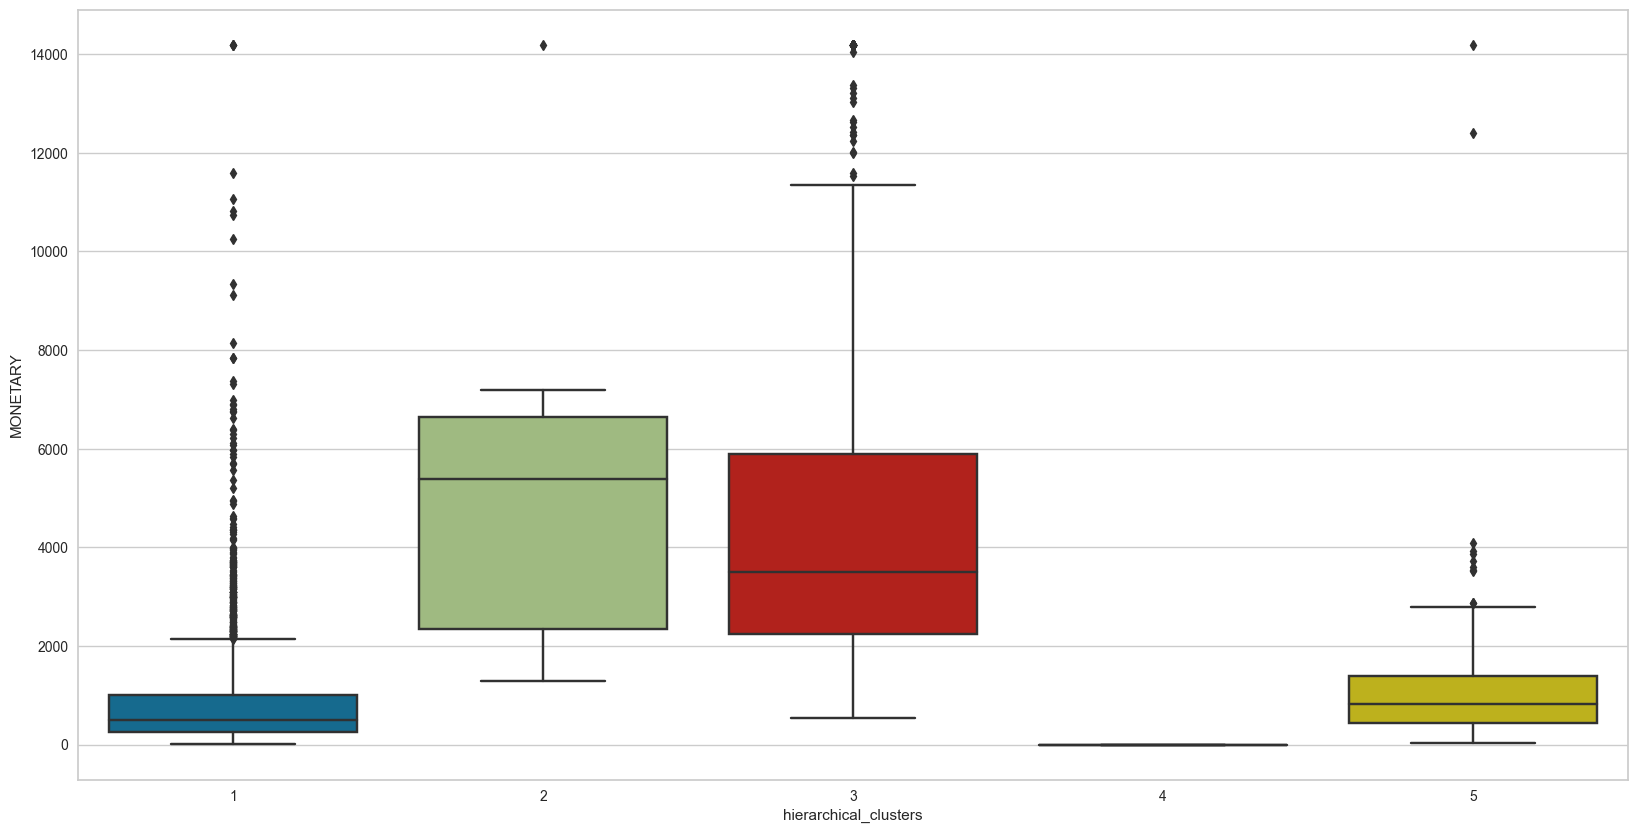

In [505]:
plt.figure(figsize=(20, 10))
sns.boxplot(x="hierarchical_clusters", y="MONETARY", data=rfm)
plt.show();